In [145]:
## Boiler plate code common to many notebooks.  See the TestFilesCommonCode.ipynb for details
from __future__ import print_function
%run TestFilesCommonCode.ipynb

SimpleITK Version: 0.10.0.dev1-g52394
Compiled: Jul  1 2015 18:02:46



In [146]:
import numpy as np

In [163]:
#^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
image='T2'
sigmaThreshold = 0.2
#^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

In [164]:
INPUT_ROOT_DIR='/raid0/homes/aghayoor/Desktop/pure_plugs/inputs'
OUTPUT_ROOT_DIR='/raid0/homes/aghayoor/Desktop/pure_plugs/outputs'
#^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

OUTPUT_MASK_NAME = 'pure_binary_mask_'+str(sigmaThreshold)+'_'+image+'.nrrd'
OUTPUT_MASK = os.path.join(OUTPUT_ROOT_DIR,OUTPUT_MASK_NAME)

OUTPUT_Label_MASK_NAME = 'pure_LABEL_mask_'+str(sigmaThreshold)+'_'+image+'.nrrd'
OUTPUT_Label_MASK = os.path.join(OUTPUT_ROOT_DIR,OUTPUT_Label_MASK_NAME)
#^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

T1fn = os.path.join(INPUT_ROOT_DIR,'t1_average_BRAINSABC.nii.gz')
T2fn = os.path.join(INPUT_ROOT_DIR,'t2_average_BRAINSABC.nii.gz')
DWIfn = os.path.join(INPUT_ROOT_DIR,'IDWI_Output.nrrd')
brain_labels_fn = os.path.join(INPUT_ROOT_DIR,'complete_brainlabels_seg.nii.gz')

In [165]:
T1_raw = sitk.ReadImage(T1fn)
T2_raw = sitk.ReadImage(T2fn)
BRAINSLabels = sitk.ReadImage(brain_labels_fn)

#------- DWI ------------
#-- either
DWI3D = sitk.ReadImage(DWIfn)
#-- OR
'''
DWI = sitk.ReadImage(DWIfn)
# crop DWI to a smaller image named DWI3D
start = [60,60,35]
size = [i/10 for i in DWI.GetSize()]
ROIFilt = sitk.RegionOfInterestImageFilter()
ROIFilt.SetIndex(start)
ROIFilt.SetSize(size)
DWI3D = ROIFilt.Execute(DWI)
sitk.WriteImage(DWI3D,'/raid0/homes/aghayoor/Desktop/pure_plugs/DWI_cropped.nrrd')
print(DWI.GetSize())
print(DWI3D.GetSize())
'''
#----------------------

purePlugsMask = sitk.Image(DWI3D.GetSize(),sitk.sitkUInt8)
purePlugsMask.CopyInformation(DWI3D)

In [166]:
normFilt1 = sitk.NormalizeImageFilter()
T13D = normFilt1.Execute(T1_raw)

normFilt2 = sitk.NormalizeImageFilter()
T23D = normFilt2.Execute(T2_raw)

In [167]:
statTest=sitk.StatisticsImageFilter()
statTest.Execute(T13D)
print(statTest.GetMaximum())
print(statTest.GetMinimum())
print(statTest.GetMean())
print(statTest.GetSigma())

2.30620340621
-0.689983735407
-7.76211027931e-13
1.0


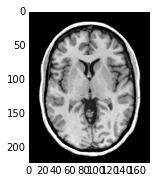

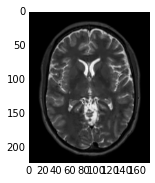

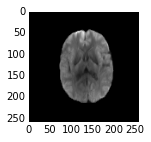

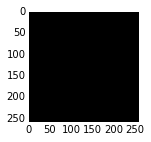

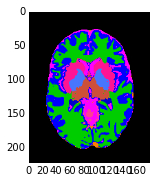

In [168]:
myshow(T13D)
myshow(T23D)
myshow(DWI3D)
myshow(purePlugsMask)
myshow(sitk.LabelToRGB(BRAINSLabels))

#print(DWI3D)
#print(purePlugsMask)

In [169]:
if image=='T1':
    MRImg = T13D
elif image=='T2':
    MRImg = T23D
else:
    raise ValueError('Define correct modality image.')

In [170]:
def isPurePlug(idx, lowResImg, highResImg, sigmaThreshold, f=0):
    # high spacing (low resolution)
    hspc=np.array(lowResImg.GetSpacing())
    # low spacing (high resolution)
    lspc=np.array(highResImg.GetSpacing())

    if f>0:
      factor=f
    else:
      factor=hspc/lspc
        
    stepSize=hspc/factor

    hresSize = highResImg.GetSize()
    
    # continues index
    cidx=np.array([float(i) for i in idx])
    #
    #print(cidx) # <-----
    #
    isInside = True
    sampleValues=[]
    for iss in np.arange(cidx[0]-hspc[0]/2+stepSize[0]/2,cidx[0]+hspc[0]/2,stepSize[0]):
        for jss in np.arange(cidx[1]-hspc[1]/2+stepSize[1]/2,cidx[1]+hspc[1]/2,stepSize[1]):
            for kss in np.arange(cidx[2]-hspc[2]/2+stepSize[2]/2,cidx[2]+hspc[2]/2,stepSize[2]):
                cssidx=[iss, jss, kss]
                #
                #print(cssidx) # <-----
                #
                p = lowResImg.TransformContinuousIndexToPhysicalPoint(cssidx)
                #
                #print("point: {0}".format(p)) # <-----
                #
                # In ITK implementation, you may need:
                # First, check wether the physical point p is inside the buffer
                # Then, get the image value directly from point p
                newidx = highResImg.TransformPhysicalPointToIndex(p)
                #
                #print("newidx: {0}".format(newidx)) # <-----
                #
                if any( newidx[i] < 0 or newidx[i] >= hresSize[i] for i in range(len(newidx))):
                    isInside = False
                    #
                    #print("is not inside") # <-----
                    #
                    break
                else:
                    value = highResImg[newidx]
                    sampleValues.append(value)
            else:
                continue
            break
        else:
            continue
        break

    ispure = False
    if isInside:
        #
        #print(sampleValues) # <-----
        #
        arr = np.array(sampleValues)
        stdValue = np.std(arr)
        #
        #print("STD value: {0}".format(stdValue)) # <-----
        #
        if stdValue < sigmaThreshold:
          ispure = True
    #
    #print("Is pure: {0}".format(ispure)) # <-----
    #
    return ispure

In [171]:
dwi_size = DWI3D.GetSize()

for i in range(0,dwi_size[0]):
  for j in range(0,dwi_size[1]):
    for k in range(0,dwi_size[2]):
      idx=[i,j,k]
      if( isPurePlug(idx,DWI3D,MRImg,sigmaThreshold) ):
        purePlugsMask[idx] = 1
      else:
        purePlugsMask[idx] = 0

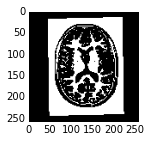

In [172]:
myshow(purePlugsMask)
sitk.WriteImage(purePlugsMask,OUTPUT_MASK)

In [173]:
# Resample purePlugMask to BABC brain label map voxel space, using default transform that is identity
resFilt = sitk.ResampleImageFilter()
resFilt.SetReferenceImage(BRAINSLabels)
resFilt.SetOutputPixelType(BRAINSLabels.GetPixelIDValue())
resFilt.SetInterpolator(sitk.sitkNearestNeighbor) # Nearest neighbor interpolation
pureMask_resampled = resFilt.Execute(purePlugsMask)

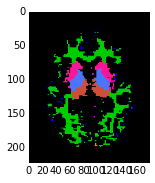

In [174]:
pure_label_mask = pureMask_resampled * BRAINSLabels

sitk.WriteImage(pure_label_mask,OUTPUT_Label_MASK)
myshow(sitk.LabelToRGB(pure_label_mask))

In [175]:
BrainlabelDic=dict(WM=1, SURFGM=2, CSF=4, VB=5, CRBLGM=11, CRBLWM=12, BASAL=19, GLOBUS=23, THALAMUS=24, HIPPOCAMPUS=25, AIR=0)
print(BrainlabelDic)

{'THALAMUS': 24, 'VB': 5, 'CRBLGM': 11, 'HIPPOCAMPUS': 25, 'GLOBUS': 23, 'SURFGM': 2, 'CSF': 4, 'AIR': 0, 'BASAL': 19, 'CRBLWM': 12, 'WM': 1}


In [176]:
statFilter = sitk.LabelStatisticsImageFilter()
statFilter.Execute(MRImg, pure_label_mask)
print('Number of lables', statFilter.GetNumberOfLabels())
print('Number of voxels for each label in the pure mask for: ',image)
print('Sigma threshold was: ', sigmaThreshold)
print('-------------------')

for key, value in BrainlabelDic.iteritems():
    labelID = int(value)
    print(key, ' : ' , statFilter.GetCount(labelID))

Number of lables 12
Number of voxels for each label in the pure mask for:  T2
Sigma threshold was:  0.2
-------------------
THALAMUS  :  17320
VB  :  4762
CRBLGM  :  6620
HIPPOCAMPUS  :  2696
GLOBUS  :  9692
SURFGM  :  23035
CSF  :  2486
AIR  :  6885404
BASAL  :  0
CRBLWM  :  21905
WM  :  272698
